In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 7.3 kB/s 
     |████████████████████████████████| 578.1 MB 27 kB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 511.8 MB 31 kB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=0cacd36e32b32f6edbd4565e663f8c14dc46ebb55ee84ba6999fb0562bd56eb4
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:

url = 'https://raw.githubusercontent.com/nicknochnack/CommentToxicity/main/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv'
df = pd.read_csv(url)

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**1. Preprocess**

In [5]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh

Tokenization using TextVectorization

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000 # number of words in the vocab


In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')


In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

Data Pipeline

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks


In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))


2. Create Sequential Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding


In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
history = model.fit(train, epochs=5, validation_data=val)


Epoch 1/5
6981/6981 [==============================] - 661s 93ms/step - loss: 0.0626 - val_loss: 0.0448
Epoch 2/5
6981/6981 [==============================] - 653s 93ms/step - loss: 0.0452 - val_loss: 0.0389
Epoch 3/5
6981/6981 [==============================] - 657s 94ms/step - loss: 0.0403 - val_loss: 0.0354
Epoch 4/5
6981/6981 [==============================] - 647s 93ms/step - loss: 0.0360 - val_loss: 0.0320
Epoch 5/5
6981/6981 [==============================] - 633s 91ms/step - loss: 0.0320 - val_loss: 0.0292


In [19]:
history.history

{'loss': [0.06264641880989075,
  0.04522056505084038,
  0.04031845182180405,
  0.03599453344941139,
  0.03196555748581886],
 'val_loss': [0.04482684284448624,
  0.038902465254068375,
  0.03543908894062042,
  0.03203210607171059,
  0.029166290536522865]}

In [20]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

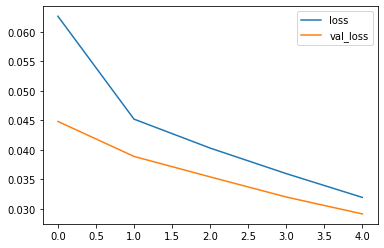

In [21]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

3. Making Predictions


In [22]:
input_text = vectorizer('You freaking suck! I am going to hit you.')


In [23]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [24]:
res = model.predict(np.expand_dims(input_text,0))
res

1/1 [==============================] - 1s 746ms/step


array([[0.9995048 , 0.299096  , 0.9859698 , 0.04635851, 0.9459891 ,
        0.18441392]], dtype=float32)

In [25]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [26]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [27]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 65ms/step


array([[1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [28]:
res = model.predict(batch_X)
res

1/1 [==============================] - 0s 64ms/step


array([[5.71695745e-01, 6.58960838e-04, 6.16990067e-02, 1.66577182e-03,
        6.52722493e-02, 2.22927704e-03],
       [9.97971475e-01, 3.96557152e-01, 9.44977939e-01, 2.10873947e-01,
        8.89795423e-01, 5.65228462e-01],
       [6.34896060e-05, 6.02685912e-16, 1.06948271e-07, 1.44951140e-09,
        4.50122883e-07, 2.71278659e-11],
       [1.70277897e-02, 9.62718545e-08, 5.99305902e-04, 8.25864990e-05,
        1.49696751e-03, 1.69509385e-05],
       [3.95759456e-02, 1.14176100e-06, 1.85776630e-03, 3.35424935e-04,
        4.31533903e-03, 1.02199527e-04],
       [4.33286978e-03, 7.16597226e-10, 6.95703857e-05, 5.37922733e-06,
        2.00892653e-04, 6.53912480e-07],
       [8.37060288e-05, 1.51768589e-15, 1.52257897e-07, 3.18331161e-09,
        7.05732987e-07, 6.84520149e-11],
       [6.80217272e-05, 7.40536183e-16, 1.11177634e-07, 1.87857130e-09,
        5.18498496e-07, 3.53907875e-11],
       [1.06392531e-02, 3.93340782e-09, 2.36835695e-04, 4.72476677e-06,
        3.76288866e-04, 

4. Evaluate Model

In [29]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy


In [30]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 59ms/step


In [32]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


Precision: 0.8498464822769165, Recall:0.8515100479125977, Accuracy:0.5095285773277283


5. Test and Gradio UI

In [33]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 35.3 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 2.3 MB 52.6 MB/s 
     |████████████████████████████████| 213 kB 64.4 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 106 kB 73.2 MB/s 
     |████████████████████████████████| 272 kB 71.6 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 80 kB 11.3 MB/s 
     |████████████████████████████████| 68 kB 2.4 MB/s 
     |████████████████████████████████| 68 kB 7.2 MB/s 
     |████████████████████████████████| 68 kB 8.0 MB/s 
     |████████████████████████████████| 46 kB 4.8

In [34]:
import tensorflow as tf
import gradio as gr

In [35]:
model.save('toxicity.h5')

In [36]:
model = tf.keras.models.load_model('toxicity.h5')

In [37]:
input_str = vectorizer('hey i freaken hate you!')

In [38]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 871ms/step


In [39]:
res

array([[0.8141764 , 0.00975377, 0.06738672, 0.05521446, 0.35619238,
        0.13175805]], dtype=float32)

In [40]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [41]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [42]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://15c0e5ccb599e6bd.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
